In [1]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
import historicdutchweather                #pip install pvlib historicdutchweather
import pytz
from typing import Tuple
import pvlib
from datetime import datetime
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Business Understanding
We kijken naar zonnepaneeldata over een periode van net iets minder naar twee jaar. De metingen bestaan uit het wattage dat elke minuut door de panelen werd opgewekt. Hierbij is de data al omgezet naar watt per vierkante meter.

We zijn op zoek naar de efficientie van de panelen. Deze kan berekend worden door de theoretische hoeveelheid opbrengst te nemen en deze te verlagen met een bepaalde factor om de werkelijke meting te benaderen. Deze factor is de efficientie.

Om deze berekening te moeten doen, maken we gebruik van de pvlib library. Hierbij is het nodig om de helling van het zonnepaneel met het dak te weten (de tilt). En ook de richting van het paneel (de azimuth). De azimuth loopt van 0 graden noord, naar 90 graden oost, naar 180 graden zuid en dan naar 270 graden west.

# Data Understanding
## Stroomproductiedata ophalen

In [2]:
df_SP = pd.read_csv('dataset.csv')
df_SP['time'] = pd.to_datetime(df_SP['time'])
df_SP = df_SP.set_index('time')

In [3]:
df_SP

,production
time,
2020-04-10 10:31:35+00:00,96.666667
2020-04-10 10:32:35+00:00,96.666667
2020-04-10 10:33:35+00:00,93.333333
2020-04-10 10:34:35+00:00,100.000000
2020-04-10 10:35:36+00:00,103.333333
...,...
2022-09-06 17:32:35+00:00,0.000000
2022-09-06 17:33:35+00:00,3.333333
2022-09-06 17:34:35+00:00,0.000000


In [4]:
# Doe hier je verder data verkenning
df_SP.isna().sum()

production    0
dtype: int64

In [5]:
df_SP.dtypes

production    float64
dtype: object

In [6]:
df_SP.shape

(1266008, 1)

In [7]:
df_SP.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
production,1266008.0,21.812874,77.228418,0.0,0.0,0.0,20.0,2206.666667


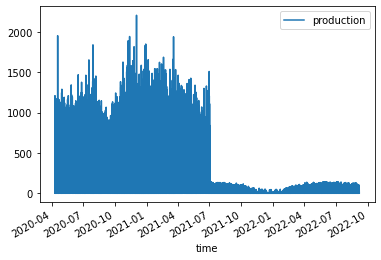

In [8]:
temp_plot = df_SP.plot()

Er ontbreekt geen data. Wat mij wel opvalt is dat er veel spikes zijn en dat de productie van stroom opeens twee tot drie keer lager is na juli/augustus. Blijkbaar komt dit een regeling dat huizen niet te veel stroom mogen produceren, omdat dit voor overbelasting zorgt voor het stroomnet.

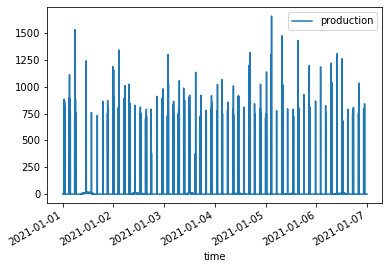

In [9]:
temp_plot = df_SP.loc['01-01-2021':'01-06-2021'].plot()

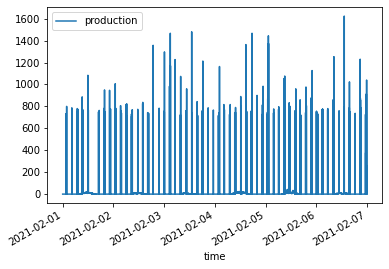

In [10]:
temp_plot = df_SP.loc['02-01-2021':'02-06-2021'].plot()

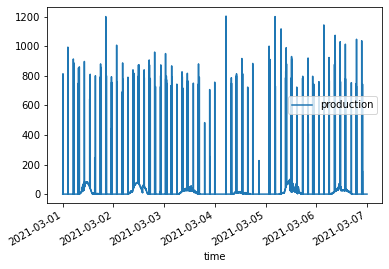

In [11]:
temp_plot = df_SP.loc['03-01-2021':'03-06-2021'].plot()

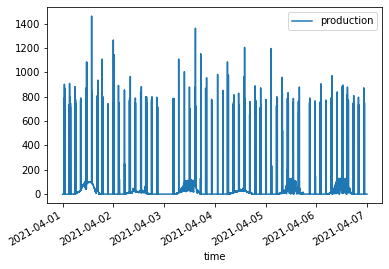

In [12]:
temp_plot = df_SP.loc['04-01-2021':'04-06-2021'].plot()

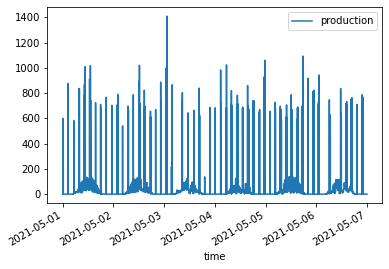

In [13]:
temp_plot = df_SP.loc['05-01-2021':'05-06-2021'].plot()

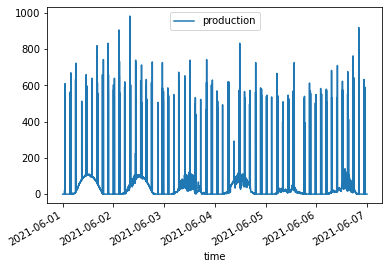

In [14]:
temp_plot = df_SP.loc['06-01-2021':'06-06-2021'].plot()

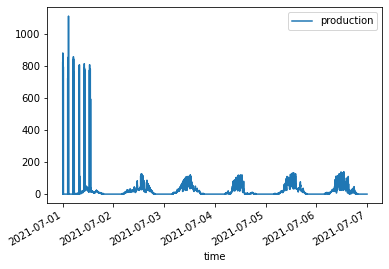

In [15]:
temp_plot = df_SP.loc['07-01-2021':'07-06-2021'].plot()

Wanneer ik per eerste week van de maand kijk valt het mij op dat de pieken van de productie in de zomer niet per se hoger ligt vergeleken met de winter. Het valt mij wel op dat er veel minder metingen zijn waar 0 op te zien is in de zomer vergeleken met de winter. 

## Weerdataset ophalen

In [16]:
# Maak gebruik van de historicdutchweather.get_local_weather functie of importeer rechtstreeks de data vanaf de KNMI site
lat = 52.5012462
lon = 6.0789505

In [17]:
df_W = pd.read_csv('weather.csv')
df_W['time'] = pd.to_datetime(df_W['time'])
df_W = df_W.set_index('time')

In [18]:
df_W

,T,FH,DD,Q,DR,RH,U,N
time,,,,,,,,
2020-04-10 00:00:00+00:00,4.461015,2.604330,56.449253,-1.482197e-323,-1.482197e-323,-1.482197e-323,85.211640,1.947349
2020-04-10 01:00:00+00:00,4.014926,2.604330,58.753726,-1.482197e-323,-1.482197e-323,-1.482197e-323,89.105820,7.088386
2020-04-10 02:00:00+00:00,3.437970,2.249255,62.304473,-1.482197e-323,-1.482197e-323,-1.482197e-323,91.230447,8.000000
2020-04-10 03:00:00+00:00,3.019567,2.124627,54.608945,-1.482197e-323,-1.482197e-323,-1.482197e-323,92.124627,8.000000
2020-04-10 04:00:00+00:00,3.175657,2.355075,60.000000,6.449253e-01,-1.482197e-323,-1.482197e-323,92.355075,8.000000
...,...,...,...,...,...,...,...,...
2022-09-05 19:00:00+00:00,18.193627,0.834777,74.608945,-1.482197e-323,-1.482197e-323,-1.482197e-323,83.281190,7.087373
2022-09-05 20:00:00+00:00,18.629837,1.728957,104.143374,-1.482197e-323,-1.482197e-323,-1.482197e-323,77.099999,8.000000
2022-09-05 21:00:00+00:00,18.296253,1.853584,127.376177,-1.482197e-323,-1.482197e-323,-1.482197e-323,81.412843,8.000000


T = Temperatuur, FH = Uurgemiddelde windsnelheid, DD Windrichting, Q = Globale Straling, DR = Duur van Neerslag, RH = Uursom van neerslag, U = Relatieve vochtigheid en N = Bewolking

Dus voor deze opdracht ga ik alleen de data gebruiken over de bewolking

In [19]:
df_W = df_W[['N']]

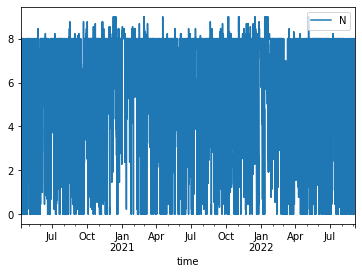

In [20]:
temp_plot = df_W.plot()

In [21]:
df_W.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
N,21025.0,5.82491,2.836864,1.867937e-317,3.964266,7.543686,8.0,9.0


## Data Preparation

## Resampling naar xx minuten

In [22]:
# Resample je data naar 5 of 10 minuten
df_10m = df_SP[df_W.index[0]:df_W.index[-1]]
df_10m = df_10m.resample('10T', origin=df_10m.index[0]).median()
df_10m[df_10m['production'] > 200] = 50 # Remove single wrong datapoint
df_10m

,production
time,
2020-04-10 10:31:35+00:00,96.666667
2020-04-10 10:41:35+00:00,80.000000
2020-04-10 10:51:35+00:00,86.666667
2020-04-10 11:01:35+00:00,90.000000
2020-04-10 11:11:35+00:00,86.666667
...,...
2022-09-05 22:11:35+00:00,0.000000
2022-09-05 22:21:35+00:00,0.000000
2022-09-05 22:31:35+00:00,0.000000


In [23]:
df_10std = df_SP[df_W.index[0]:df_W.index[-1]]
df_10std = df_10std.resample('10T', origin=df_10std.index[0]).std()
df_10std[df_10std['production'] > 200] = 50 # Remove single wrong datapoint
df_10std.head()

,production
time,
2020-04-10 10:31:35+00:00,50.000000
2020-04-10 10:41:35+00:00,5.163978
2020-04-10 10:51:35+00:00,4.444444
2020-04-10 11:01:35+00:00,50.000000
2020-04-10 11:11:35+00:00,3.865006


In [24]:
df_15m = df_SP[df_W.index[0]:df_W.index[-1]]
df_15m = df_15m.resample('15T', origin=df_15m.index[0]).median()
df_15m[df_15m['production'] > 200] = 50 # Remove single wrong datapoint
df_15m

,production
time,
2020-04-10 10:31:35+00:00,93.333333
2020-04-10 10:46:35+00:00,86.666667
2020-04-10 11:01:35+00:00,90.000000
2020-04-10 11:16:35+00:00,81.666667
2020-04-10 11:31:35+00:00,61.666667
...,...
2022-09-05 21:46:35+00:00,0.000000
2022-09-05 22:01:35+00:00,0.000000
2022-09-05 22:16:35+00:00,0.000000


In [25]:
df_15std = df_SP[df_W.index[0]:df_W.index[-1]]
df_15std = df_15std.resample('15T', origin=df_15std.index[0]).std()
df_15std[df_15std['production'] > 200] = 50 # Remove single wrong datapoint
df_15std.head()

,production
time,
2020-04-10 10:31:35+00:00,191.860013
2020-04-10 10:46:35+00:00,3.751543
2020-04-10 11:01:35+00:00,50.000000
2020-04-10 11:16:35+00:00,5.927806
2020-04-10 11:31:35+00:00,50.000000


Ik ga de dataframe df_10m gebruiken. Deze dataframe is geresampled op basis van de mean en voor elke 10 minuten. Ik heb hiervoor gekomen, omdat het gemiddelde heel erg onbetrouwbaar oogt. Het gaat van 191 naar 3 naar 50 naar 5 en weer terug naar 50. 

## Weer en zonnepanelen combineren

In [26]:
# Combineer de zonnepaneel en weerdata
# Interpoleer de ontbrekende waarden, zodat de weerdata ook per xx minuten beschikbaar is
df_combined = pd.DataFrame({'production': df_10m['production'], 'weather': df_W['N']})
df_combined['weather'] = df_combined['weather'].astype(float).interpolate(method='time')
df_combined = df_combined[df_combined['production'].notna()]

In [27]:
df_combined.head()

,production,weather
time,,
2020-04-10 10:31:35+00:00,96.666667,6.742752
2020-04-10 10:41:35+00:00,80.000000,6.944584
2020-04-10 10:51:35+00:00,86.666667,7.146415
2020-04-10 11:01:35+00:00,90.000000,7.322303
2020-04-10 11:11:35+00:00,86.666667,7.360287


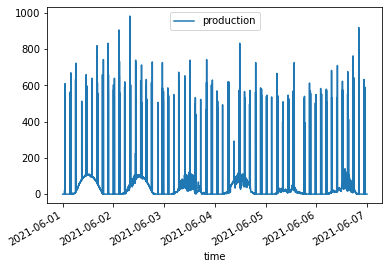

In [28]:
#DF plot die niet geresampled is
temp_plot = df_SP.loc['06-01-2021':'06-06-2021'].plot()

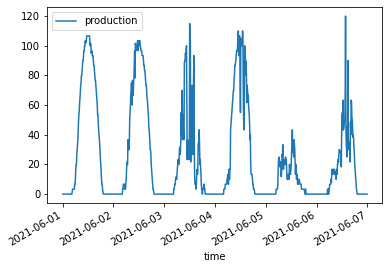

In [29]:
#DF plot die geresampled is
temp_plot = df_10m.loc['06-01-2021':'06-06-2021'].plot()

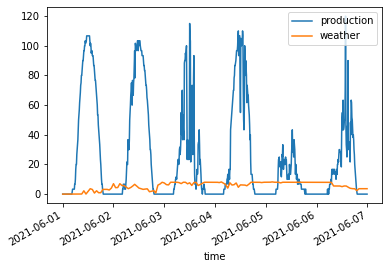

In [30]:
#DF plot die gecombineerd is
temp_plot = df_combined.loc['06-01-2021':'06-06-2021'].plot()

Het resultaat van dit is dat het duidelijk is wanneer er nacht is en wanneer er veel bevolking is. In de laatste plot is wel eits raars zichtbaar. De derde en vierde piek hebben ongeveer dezelfde hoeveelheeid bewolking als de vijfde piek maar die heeft maar de helft van de stroomproductie dan de andere twee pieken. Mijn aanname is dat de dikte van de bewolking ook een rol speelt maar dit in niet met de huidge dataset af te lezen> 

## Filter op zonnige dagen

# Modeling

In [31]:
# Gegeven:
def model_zonnestraling(tilt:float, azimuth:float, tijdsreeks:pd.core.indexes.datetimes.DatetimeIndex, lat:float, lon:float) -> pd.DataFrame:
    """Berekent de hoeveelheid stroom die een paneel maximaal produceert met 100% efficientie"""
    
    zonne_positie_aan_hemel = pvlib.solarposition.get_solarposition(tijdsreeks, lat, lon)

    #locatie = pvlib.location.Location(latitude=lat, longitude=lon, name='Plaatsnaam', tz=pytz.timezone(r'Europe/Amsterdam'))
    locatie = pvlib.location.Location(latitude=lat, longitude=lon, name='Plaatsnaam', tz=pytz.timezone(r'UTC'))
    heldere_hemel = locatie.get_clearsky(tijdsreeks)  

    instraling = pvlib.irradiance.get_total_irradiance(tilt, 
                                                       azimuth, 
                                                       zonne_positie_aan_hemel['zenith'], 
                                                       zonne_positie_aan_hemel['azimuth'], 
                                                       heldere_hemel.dni, 
                                                       heldere_hemel.ghi, 
                                                       heldere_hemel.dhi)    
    
    return instraling['poa_global'].to_frame().rename(columns={'poa_global':'zonlicht'})

In [32]:
# Aanvullen
def model_paneel(tilt:float, azimuth:float, efficientie:float, tijdsreeks:pd.core.indexes.datetimes.DatetimeIndex, lat:float, lon:float) -> pd.DataFrame:
    """Berekent de hoeveelheid geabsorbeerd zonlicht op een paneel op basis van de efficientie"""
    
    return model_zonnestraling(tilt, azimuth, tijdsreeks, lat, lon) * efficientie

In [33]:
# Aanvullen
def loss(params:Tuple[float,float,float], df_waarneming:pd.DataFrame, lat:float, lon:float) -> float:
    
    (tilt, azimuth, efficientie) = params
    
    tijdsreeks = df_waarneming.index
    
    df_model = model_paneel(tilt, azimuth, efficientie, tijdsreeks, lat, lon)
    
    return np.sum((df_model['zonlicht'] - df_waarneming['production'])**2)

In [34]:
# Eerste inschatting
tilt = 35   
azimuth = 180
efficientie = 0.2

In [35]:
df_all1 = df_combined[df_combined['weather'] < 1]
df_all2 = df_combined[df_combined['weather'] < 2]
df_all3 = df_combined[df_combined['weather'] < 3]
df_all4 = df_combined[df_combined['weather'] < 4]
df_all5 = df_combined[df_combined['weather'] < 5]

In [36]:
df_week1 = df_combined[df_combined['weather'] < 1].loc['06-01-2021':'06-06-2021']
df_week2 = df_combined[df_combined['weather'] < 2].loc['06-01-2021':'06-06-2021']
df_week3 = df_combined[df_combined['weather'] < 3].loc['06-01-2021':'06-06-2021']
df_week4 = df_combined[df_combined['weather'] < 4].loc['06-01-2021':'06-06-2021']
df_week5 = df_combined[df_combined['weather'] < 5].loc['06-01-2021':'06-06-2021']

In [37]:
result = minimize(loss, (tilt, azimuth, efficientie), (df_all1, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))
result_all1 = result['x']

In [38]:
result = minimize(loss, (tilt, azimuth, efficientie), (df_all2, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))
result_all2 = result['x']

In [39]:
result = minimize(loss, (tilt, azimuth, efficientie), (df_all3, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))
result_all3 = result['x']

In [40]:
result = minimize(loss, (tilt, azimuth, efficientie), (df_all4, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))
result_all4 = result['x']

In [41]:
result = minimize(loss, (tilt, azimuth, efficientie), (df_all5, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))
result_all5 = result['x']

In [42]:
result = minimize(loss, (tilt, azimuth, efficientie), (df_week1, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))
result_week1 = result['x']

In [43]:
result = minimize(loss, (tilt, azimuth, efficientie), (df_week2, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))
result_week2 = result['x']

In [44]:
result = minimize(loss, (tilt, azimuth, efficientie), (df_week3, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))
result_week3 = result['x']

In [45]:
result = minimize(loss, (tilt, azimuth, efficientie), (df_week4, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))
result_week4 = result['x']

In [46]:
result = minimize(loss, (tilt, azimuth, efficientie), (df_week5, lat, lon), bounds=((0, 45), (90, 270), (0.05, 0.3)))
result_week5 = result['x']

## Evaluation

In [47]:
display(Markdown("### Resultaat hele dataset waar de bewolking onder de 1 is behouden"))
print("Tilt:        {0:.1f}°".format(result_all1[0]))
print("Azimuth:     {0:.1f}°".format(result_all1[1]))
print("Efficientie: {0:.1f}%".format(result_all1[2]*100))

display(Markdown("### Resultaat hele dataset waar de bewolking onder de 2 is behouden"))
print("Tilt:        {0:.1f}°".format(result_all2[0]))
print("Azimuth:     {0:.1f}°".format(result_all2[1]))
print("Efficientie: {0:.1f}%".format(result_all2[2]*100))

display(Markdown("### Resultaat hele dataset waar de bewolking onder de 3 is behouden"))
print("Tilt:        {0:.1f}°".format(result_all3[0]))
print("Azimuth:     {0:.1f}°".format(result_all3[1]))
print("Efficientie: {0:.1f}%".format(result_all3[2]*100))

display(Markdown("### Resultaat hele dataset waar de bewolking onder de 4 is behouden"))
print("Tilt:        {0:.1f}°".format(result_all4[0]))
print("Azimuth:     {0:.1f}°".format(result_all4[1]))
print("Efficientie: {0:.1f}%".format(result_all4[2]*100))

display(Markdown("### Resultaat hele dataset waar de bewolking onder de 5 is behouden"))
print("Tilt:        {0:.1f}°".format(result_all5[0]))
print("Azimuth:     {0:.1f}°".format(result_all5[1]))
print("Efficientie: {0:.1f}%".format(result_all5[2]*100))

### Resultaat hele dataset waar de bewolking onder de 1 is behouden

Tilt:        12.0°
Azimuth:     231.1°
Efficientie: 11.5%


### Resultaat hele dataset waar de bewolking onder de 2 is behouden

Tilt:        11.2°
Azimuth:     231.7°
Efficientie: 11.5%


### Resultaat hele dataset waar de bewolking onder de 3 is behouden

Tilt:        10.5°
Azimuth:     234.1°
Efficientie: 11.4%


### Resultaat hele dataset waar de bewolking onder de 4 is behouden

Tilt:        10.0°
Azimuth:     232.4°
Efficientie: 11.1%


### Resultaat hele dataset waar de bewolking onder de 5 is behouden

Tilt:        9.2°
Azimuth:     233.2°
Efficientie: 10.9%


In [48]:
display(Markdown("### Resultaat één week van de dataset waar de bewolking onder de 1 is behouden"))
print("Tilt:        {0:.1f}°".format(result_week1[0]))
print("Azimuth:     {0:.1f}°".format(result_week1[1]))
print("Efficientie: {0:.1f}%".format(result_week1[2]*100))

display(Markdown("### Resultaat één week van de dataset waar de bewolking onder de 2 is behouden"))
print("Tilt:        {0:.1f}°".format(result_week2[0]))
print("Azimuth:     {0:.1f}°".format(result_week2[1]))
print("Efficientie: {0:.1f}%".format(result_week2[2]*100))

display(Markdown("### Resultaat één week van de dataset waar de bewolking onder de 3 is behouden"))
print("Tilt:        {0:.1f}°".format(result_week3[0]))
print("Azimuth:     {0:.1f}°".format(result_week3[1]))
print("Efficientie: {0:.1f}%".format(result_week3[2]*100))

display(Markdown("### Resultaat één week van de dataset waar de bewolking onder de 4 is behouden"))
print("Tilt:        {0:.1f}°".format(result_week4[0]))
print("Azimuth:     {0:.1f}°".format(result_week4[1]))
print("Efficientie: {0:.1f}%".format(result_week4[2]*100))

display(Markdown("### Resultaat één week van de dataset waar de bewolking onder de 5 is behouden"))
print("Tilt:        {0:.1f}°".format(result_week5[0]))
print("Azimuth:     {0:.1f}°".format(result_week5[1]))
print("Efficientie: {0:.1f}%".format(result_week5[2]*100))

### Resultaat één week van de dataset waar de bewolking onder de 1 is behouden

Tilt:        26.0°
Azimuth:     207.3°
Efficientie: 11.6%


### Resultaat één week van de dataset waar de bewolking onder de 2 is behouden

Tilt:        25.9°
Azimuth:     206.2°
Efficientie: 11.5%


### Resultaat één week van de dataset waar de bewolking onder de 3 is behouden

Tilt:        25.7°
Azimuth:     206.1°
Efficientie: 11.5%


### Resultaat één week van de dataset waar de bewolking onder de 4 is behouden

Tilt:        23.4°
Azimuth:     207.2°
Efficientie: 11.1%


### Resultaat één week van de dataset waar de bewolking onder de 5 is behouden

Tilt:        25.9°
Azimuth:     201.3°
Efficientie: 10.8%


Er is weinig verschil in efficientie tussen het model wat alle date gebruikt of één random gekoze week.

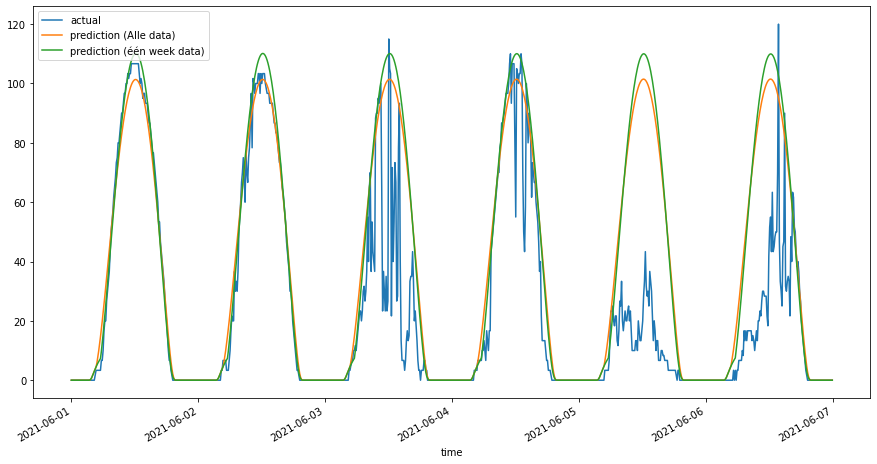

In [49]:
datetime = df_combined.loc['06-01-2021':'06-06-2021']
pred_all = model_paneel(result_all3[0], result_all3[1], result_all3[2], datetime.index, lat, lon)
pred_week = model_paneel(result_week3[0], result_week3[1], result_week3[2], datetime.index, lat, lon)
result = pd.DataFrame({
    'actual': datetime['production'], 
    'prediction (Alle data)': pred_all['zonlicht'],
    'prediction (één week data)': pred_week['zonlicht']})

temp_result = result.plot(figsize=(15,8))

Wat mij opvalt is dat alle data lager uitvalt dan de data van één week. Ik denk een goed vervolg van dit onderzoek is te kijken naar de dichtheid van de bewolking, omdat ik mij nog steeds afvraag hoe de vijfde piek zo laag is wanneer het even veel bewolking had.